In [120]:
# import libraries
import pandas as pd
import texthero as hero
from texthero import preprocessing
from scipy import spatial
from nltk.corpus import stopwords
import re
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import helpers

In [121]:
# read files
df_prod_tech_specs = pd.read_csv("data/products_technical_specs.csv")
df_prod_titles = pd.read_csv("data/products_titles.csv")

# 1. Prepare and clean data

Here we have a initial look at the data, clean and prepare them. Here is what we do:
 - Have a qualitative look what information might be hidden inside the data.
 - Check how many datapoint there are.
 - Check for null values.
 - Check for duplicates and possibly investigate, why they might be there.
 - Check, if the points in the datasets match up.

## titles

In [122]:
df_prod_titles

,Product_No,Product_title
0,1000,Renkforce Strom Verlängerungskabel [1x IDE-Str...
1,1001,Renkforce Strom Anschlusskabel [1x ATX-Strom-S...
2,1002,Akasa Strom Adapter [2x SATA-Strom-Stecker 15p...
3,1003,LogiLink Kaltgeräte Anschlusskabel [1x Schutzk...
4,1004,Digitus RJ45 Netzwerk Anschlusskabel CAT 5e U/...
5,1006,Renkforce RJ45 Netzwerk Verlängerungskabel CAT...
6,1005,BKL Electronic 073331 Kaltgeräte-Adapter Kaltg...
7,1007,Netz-Anschlusskabel Kleeblatt-Buchse C5 - Kabe...
8,1008,Neutrik NKFCA30-0 Netz-Anschlusskabel PowerCon...
9,1009,SIROX 346.310.04 Strom Verlängerungskabel 16 A...


In [123]:
df_prod_titles.info()
# => 26 rows, no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product_No     26 non-null     int64 
 1   Product_title  26 non-null     object
dtypes: int64(1), object(1)
memory usage: 544.0+ bytes


In [124]:
# check every column for duplicates
[df_prod_titles[col].unique().size for col in df_prod_titles]
# => no duplicates

[26, 26]

## specs

In [125]:
df_prod_tech_specs
# => Product_tech_specs contains multiple information (split by | and create extra columns)

,Product_No,Product_tech_specs
0,1000,AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...
1,1001,AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...
2,1002,"Anschluss-Typ: SATA, PCI-Express|Anschlusstyp ..."
3,1003,Anschluss-Typ: Kaltgeräte|Anschlusstyp A (bzw....
4,1004,AWG: 26/7|Anschluss-Typ: RJ45|Anschlusstyp A (...
5,1005,Anschlusstyp A (bzw. Eingänge): Kaltgeräte-Ste...
6,1007,Anschlusstyp A (bzw. Eingänge): Kleeblatt-...
7,1008,Anschlusstyp A (bzw. Eingänge): PowerCon-Buchs...
8,1009,Anschlusstyp A (bzw. Eingänge): Schutzkontakt-...
9,1006,AWG: 26/7|Anschluss-Typ: RJ45|||Anschlusstyp A...


In [126]:
df_prod_tech_specs.info()
# => 26 rows, no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Product_No          26 non-null     int64 
 1   Product_tech_specs  26 non-null     object
dtypes: int64(1), object(1)
memory usage: 544.0+ bytes


In [127]:
# check every column for duplicates
[df_prod_tech_specs[col].unique().size for col in df_prod_tech_specs]
# => no duplicates

[26, 26]

## Combine datasets

In [128]:
# check, if all ids match
print("If all are true, all product ids are present in both datasets.")
df_prod_titles["Product_No"].sort_values().reset_index(drop=True) == df_prod_tech_specs["Product_No"].sort_values().reset_index(drop=True)
# => they do (no False)

If all are true, all product ids are present in both datasets.


0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
Name: Product_No, dtype: bool

In [129]:
df_prod = df_prod_titles.merge(df_prod_tech_specs, on="Product_No")
df_prod

,Product_No,Product_title,Product_tech_specs
0,1000,Renkforce Strom Verlängerungskabel [1x IDE-Str...,AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...
1,1001,Renkforce Strom Anschlusskabel [1x ATX-Strom-S...,AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...
2,1002,Akasa Strom Adapter [2x SATA-Strom-Stecker 15p...,"Anschluss-Typ: SATA, PCI-Express|Anschlusstyp ..."
3,1003,LogiLink Kaltgeräte Anschlusskabel [1x Schutzk...,Anschluss-Typ: Kaltgeräte|Anschlusstyp A (bzw....
4,1004,Digitus RJ45 Netzwerk Anschlusskabel CAT 5e U/...,AWG: 26/7|Anschluss-Typ: RJ45|Anschlusstyp A (...
5,1006,Renkforce RJ45 Netzwerk Verlängerungskabel CAT...,AWG: 26/7|Anschluss-Typ: RJ45|||Anschlusstyp A...
6,1005,BKL Electronic 073331 Kaltgeräte-Adapter Kaltg...,Anschlusstyp A (bzw. Eingänge): Kaltgeräte-Ste...
7,1007,Netz-Anschlusskabel Kleeblatt-Buchse C5 - Kabe...,Anschlusstyp A (bzw. Eingänge): Kleeblatt-...
8,1008,Neutrik NKFCA30-0 Netz-Anschlusskabel PowerCon...,Anschlusstyp A (bzw. Eingänge): PowerCon-Buchs...
9,1009,SIROX 346.310.04 Strom Verlängerungskabel 16 A...,Anschlusstyp A (bzw. Eingänge): Schutzkontakt-...


## 2. Calculate all product similarities via TF-IDF

Here we will
 1. Clean title and specs.
 2. Vectorize title and text with TF-IDF.
 3. Calculate cosine similarities.

In [130]:
# Clean title and specs

# this is the default pipeline from texthero, but uses german stopwords and removes quantity tokens like 2x (they make no sense in word bag algorithms)
clean_pipeline = [
    preprocessing.fillna,
    preprocessing.lowercase,
    preprocessing.remove_digits,
    preprocessing.remove_punctuation,
    preprocessing.remove_diacritics,
    lambda s: preprocessing.remove_stopwords(s, stopwords=stopwords.words("german")),
    lambda s: pd.Series([re.sub(r"\d{0,2}x", "", e) for e in s]),
    preprocessing.remove_whitespace,
]

clean_title = hero.clean(df_prod["Product_title"], clean_pipeline)
clean_specs = hero.clean(df_prod["Product_tech_specs"], clean_pipeline)

df_prod_cleaned = df_prod.copy()
df_prod_cleaned.insert(2, 'Product_title_clean', clean_title)
df_prod_cleaned.insert(4, 'Product_tech_specs_clean', clean_specs)
df_prod_cleaned

,Product_No,Product_title,Product_title_clean,Product_tech_specs,Product_tech_specs_clean
0,1000,Renkforce Strom Verlängerungskabel [1x IDE-Str...,renkforce strom verlangerungskabel ide strom s...,AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...,awg abschirmung schirmung anschluss typ ide an...
1,1001,Renkforce Strom Anschlusskabel [1x ATX-Strom-S...,renkforce strom anschlusskabel at strom stecke...,AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...,awg abschirmung schirmung anschluss typ mainbo...
2,1002,Akasa Strom Adapter [2x SATA-Strom-Stecker 15p...,akasa strom adapter sata strom stecker 15pol p...,"Anschluss-Typ: SATA, PCI-Express|Anschlusstyp ...",anschluss typ sata pci epress anschlusstyp a b...
3,1003,LogiLink Kaltgeräte Anschlusskabel [1x Schutzk...,logilink kaltgerate anschlusskabel schutzkonta...,Anschluss-Typ: Kaltgeräte|Anschlusstyp A (bzw....,anschluss typ kaltgerate anschlusstyp a bzw ei...
4,1004,Digitus RJ45 Netzwerk Anschlusskabel CAT 5e U/...,digitus rj45 netzwerk anschlusskabel cat 5e u ...,AWG: 26/7|Anschluss-Typ: RJ45|Anschlusstyp A (...,awg anschluss typ rj45 anschlusstyp a bzw eing...
5,1006,Renkforce RJ45 Netzwerk Verlängerungskabel CAT...,renkforce rj45 netzwerk verlangerungskabel cat...,AWG: 26/7|Anschluss-Typ: RJ45|||Anschlusstyp A...,awg anschluss typ rj45 anschlusstyp a bzw eing...
6,1005,BKL Electronic 073331 Kaltgeräte-Adapter Kaltg...,bkl electronic kaltgerate adapter kaltgerate s...,Anschlusstyp A (bzw. Eingänge): Kaltgeräte-Ste...,anschlusstyp a bzw eingange kaltgerate stecker...
7,1007,Netz-Anschlusskabel Kleeblatt-Buchse C5 - Kabe...,netz anschlusskabel kleeblatt buchse c5 kabel ...,Anschlusstyp A (bzw. Eingänge): Kleeblatt-...,anschlusstyp a bzw eingange kleeblatt buchse c...
8,1008,Neutrik NKFCA30-0 Netz-Anschlusskabel PowerCon...,neutrik nkfca30 netz anschlusskabel powercon b...,Anschlusstyp A (bzw. Eingänge): PowerCon-Buchs...,anschlusstyp a bzw eingange powercon buchse an...
9,1009,SIROX 346.310.04 Strom Verlängerungskabel 16 A...,siro strom verlangerungskabel a rot m,Anschlusstyp A (bzw. Eingänge): Schutzkontakt-...,anschlusstyp a bzw eingange schutzkontakt gumm...


In [131]:
# vectorize title and specs with TF-IDF

tfidf_title = hero.tfidf(df_prod_cleaned["Product_title_clean"])
tfidf_specs = hero.tfidf(df_prod_cleaned["Product_tech_specs_clean"])

df_prod_vectorized = df_prod_cleaned.copy()
df_prod_vectorized.insert(3, 'Product_title_tfidf', tfidf_title)
df_prod_vectorized.insert(6, 'Product_tech_specs_tfidf', tfidf_specs)
df_prod_vectorized

,Product_No,Product_title,Product_title_clean,Product_title_tfidf,Product_tech_specs,Product_tech_specs_clean,Product_tech_specs_tfidf
0,1000,Renkforce Strom Verlängerungskabel [1x IDE-Str...,renkforce strom verlangerungskabel ide strom s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.476...",AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...,awg abschirmung schirmung anschluss typ ide an...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28798477..."
1,1001,Renkforce Strom Anschlusskabel [1x ATX-Strom-S...,renkforce strom anschlusskabel at strom stecke...,"[0.0, 0.0, 0.26167567477377623, 0.0, 0.2616756...",AWG: 18|Abschirmung: ohne Schirmung|Anschluss-...,awg abschirmung schirmung anschluss typ mainbo...,"[0.0, 0.15667965306238205, 0.0, 0.156679653062..."
2,1002,Akasa Strom Adapter [2x SATA-Strom-Stecker 15p...,akasa strom adapter sata strom stecker 15pol p...,"[0.0, 0.0, 0.0, 0.29389202578095047, 0.0, 0.0,...","Anschluss-Typ: SATA, PCI-Express|Anschlusstyp ...",anschluss typ sata pci epress anschlusstyp a b...,"[0.0, 0.0, 0.15538697268732848, 0.0, 0.0, 0.0,..."
3,1003,LogiLink Kaltgeräte Anschlusskabel [1x Schutzk...,logilink kaltgerate anschlusskabel schutzkonta...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Anschluss-Typ: Kaltgeräte|Anschlusstyp A (bzw....,anschluss typ kaltgerate anschlusstyp a bzw ei...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1004,Digitus RJ45 Netzwerk Anschlusskabel CAT 5e U/...,digitus rj45 netzwerk anschlusskabel cat 5e u ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AWG: 26/7|Anschluss-Typ: RJ45|Anschlusstyp A (...,awg anschluss typ rj45 anschlusstyp a bzw eing...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.143..."
5,1006,Renkforce RJ45 Netzwerk Verlängerungskabel CAT...,renkforce rj45 netzwerk verlangerungskabel cat...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AWG: 26/7|Anschluss-Typ: RJ45|||Anschlusstyp A...,awg anschluss typ rj45 anschlusstyp a bzw eing...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1005,BKL Electronic 073331 Kaltgeräte-Adapter Kaltg...,bkl electronic kaltgerate adapter kaltgerate s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Anschlusstyp A (bzw. Eingänge): Kaltgeräte-Ste...,anschlusstyp a bzw eingange kaltgerate stecker...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,1007,Netz-Anschlusskabel Kleeblatt-Buchse C5 - Kabe...,netz anschlusskabel kleeblatt buchse c5 kabel ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Anschlusstyp A (bzw. Eingänge): Kleeblatt-...,anschlusstyp a bzw eingange kleeblatt buchse c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,1008,Neutrik NKFCA30-0 Netz-Anschlusskabel PowerCon...,neutrik nkfca30 netz anschlusskabel powercon b...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Anschlusstyp A (bzw. Eingänge): PowerCon-Buchs...,anschlusstyp a bzw eingange powercon buchse an...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,1009,SIROX 346.310.04 Strom Verlängerungskabel 16 A...,siro strom verlangerungskabel a rot m,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Anschlusstyp A (bzw. Eingänge): Schutzkontakt-...,anschlusstyp a bzw eingange schutzkontakt gumm...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1671025477624..."


In [132]:
# Generate combinations
df_prod_combinations = df_prod_vectorized.merge(df_prod_vectorized, how="cross")

# Calculate cosine similarities
df_prod_combinations["Similarity_based_on_title"] = df_prod_combinations.apply(lambda row: 1 - spatial.distance.cosine(row["Product_title_tfidf_x"], row["Product_title_tfidf_y"]), axis=1)
df_prod_combinations["Similarity_based_on_tech_specs"] = df_prod_combinations.apply(lambda row: 1 - spatial.distance.cosine(row["Product_tech_specs_tfidf_x"], row["Product_tech_specs_tfidf_y"]), axis=1)

df_prod_combinations[["Product_No_x", "Product_No_y", "Similarity_based_on_title", "Similarity_based_on_tech_specs"]]

,Product_No_x,Product_No_y,Similarity_based_on_title,Similarity_based_on_tech_specs
0,1000,1000,1.000000,1.000000
1,1000,1001,0.443681,0.694942
2,1000,1002,0.415386,0.606109
3,1000,1003,0.110667,0.423587
4,1000,1004,0.049156,0.443013
...,...,...,...,...
671,1025,1021,0.039476,0.061612
672,1025,1022,0.020109,0.103393
673,1025,1023,0.024500,0.074423
674,1025,1024,0.448040,0.694759


# 3 Visualize differences in similarities

We visualize the difference between the two similarities in a matrix. This is a concise way to get a good over view of all the data.

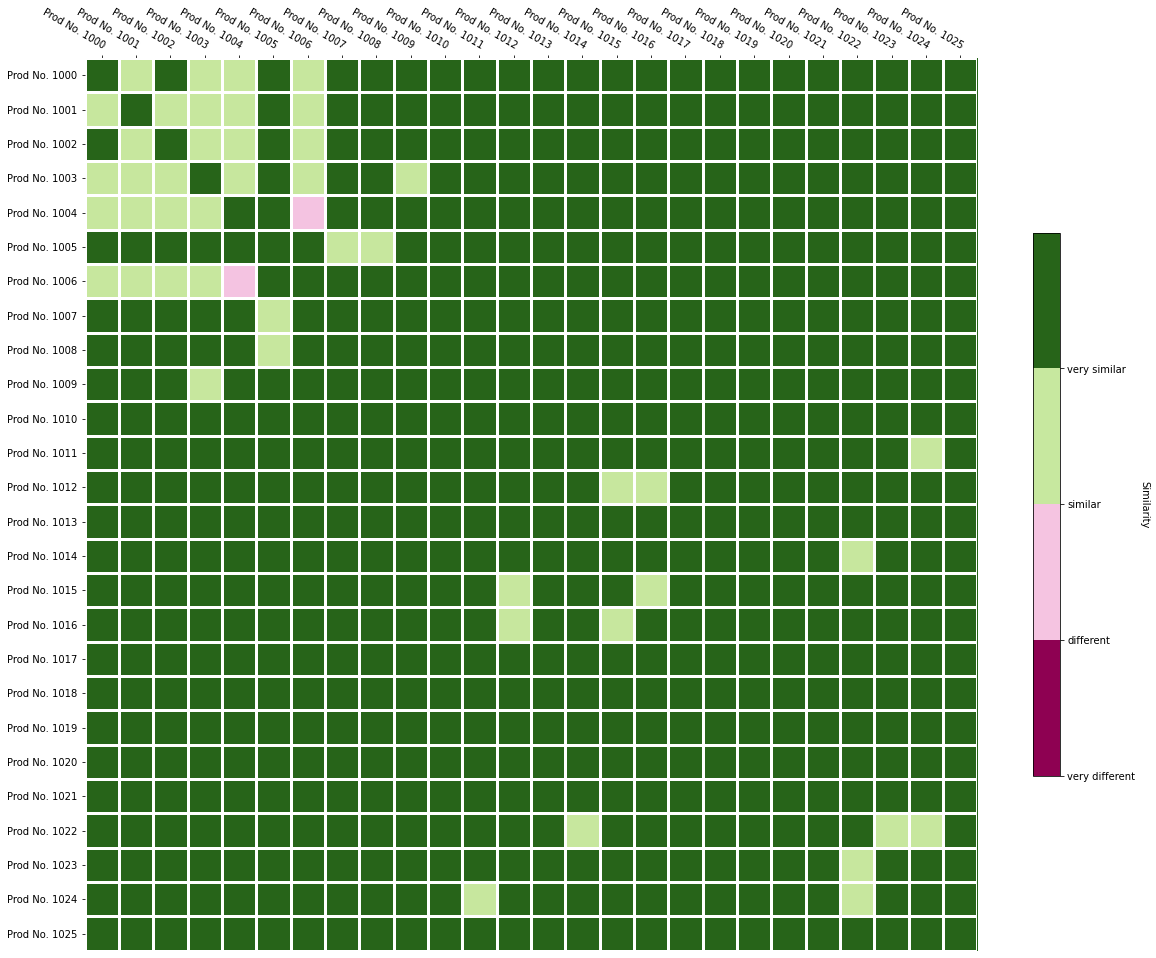

In [133]:
# Calculate the difference between differences and generate a matrix from it (0: very similar; 1: very different)
df_prod_combinations["Similarity_difference"] = abs(df_prod_combinations["Similarity_based_on_title"] - df_prod_combinations["Similarity_based_on_tech_specs"])

similarity_matrix = df_prod_combinations.pivot(index="Product_No_x", columns="Product_No_y", values="Similarity_difference")

# Visualize the difference matrix
plt.figure(figsize=(20,20))

data = 1 - similarity_matrix
y = ["Prod No. {}".format(i) for i in similarity_matrix.index]
x = ["Prod No. {}".format(i) for i in similarity_matrix.columns]

qrates = ["very similar", "similar", "different", "very different"]
norm = matplotlib.colors.BoundaryNorm(np.linspace(0, 1, len(qrates)+1), len(qrates))
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])

im, cbar = helpers.heatmap(data, y, x,
                cmap=plt.get_cmap("PiYG", len(qrates)), norm=norm,
                cbar_kw=dict(ticks=np.linspace(0, 1, len(qrates), endpoint=False), format=fmt, shrink=0.5),
                cbarlabel="Similarity", )

# 4 Conclusion

We have a look at some specific data points and draw a conclusion.

In [134]:
# only the similarities of Products 1004 and 1006 seem to be different, let's look at them
df_prod_combinations[(df_prod_combinations["Product_No_x"] == 1004) & (df_prod_combinations["Product_No_y"] == 1006)][["Product_title_x", "Product_title_y", "Similarity_based_on_title", "Product_tech_specs_x", "Product_tech_specs_y", "Similarity_based_on_tech_specs", "Similarity_difference"]]

# => there is a big difference between the two similarities

,Product_title_x,Product_title_y,Similarity_based_on_title,Product_tech_specs_x,Product_tech_specs_y,Similarity_based_on_tech_specs,Similarity_difference
109,Digitus RJ45 Netzwerk Anschlusskabel CAT 5e U/...,Renkforce RJ45 Netzwerk Verlängerungskabel CAT...,0.282735,AWG: 26/7|Anschluss-Typ: RJ45|Anschlusstyp A (...,AWG: 26/7|Anschluss-Typ: RJ45|||Anschlusstyp A...,0.837659,0.554924


**About Product 1004 and 1006:**
The similarity based on the titles is not very high, but the similarity based on the tech specs is.
From a qualitative view the products are rather similar. Both are network cables, but one is a extension cable.
It seems that the differences in the titles come mainly from additional information like color or manufacturer.
The fact, that they are similar products is not reflected in the titles very well, because the noise of unnecessary information is relatively big.
This is not the case for the tech specs, because there are more information, that proof the similarity and outweigh the noise.



## Conclusion

As a conclusion one can say, that the titles are a worse way of identifying similar products than their tech specs, because there simply is not very much information to compared to the tech specs.